[*********************100%***********************]  20 of 20 completed

✅ Loaded data for 18 tickers.



/var/folders/1p/5h7kbx8552l0dbm3x46kqd3c0000gn/T/ipykernel_52649/3933479021.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = data.resample('M').last()
[*********************100%***********************]  1 of 1 completed
/var/folders/1p/5h7kbx8552l0dbm3x46kqd3c0000gn/T/ipykernel_52649/3933479021.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ftse_monthly = ftse_index.resample('M').last().pct_change()


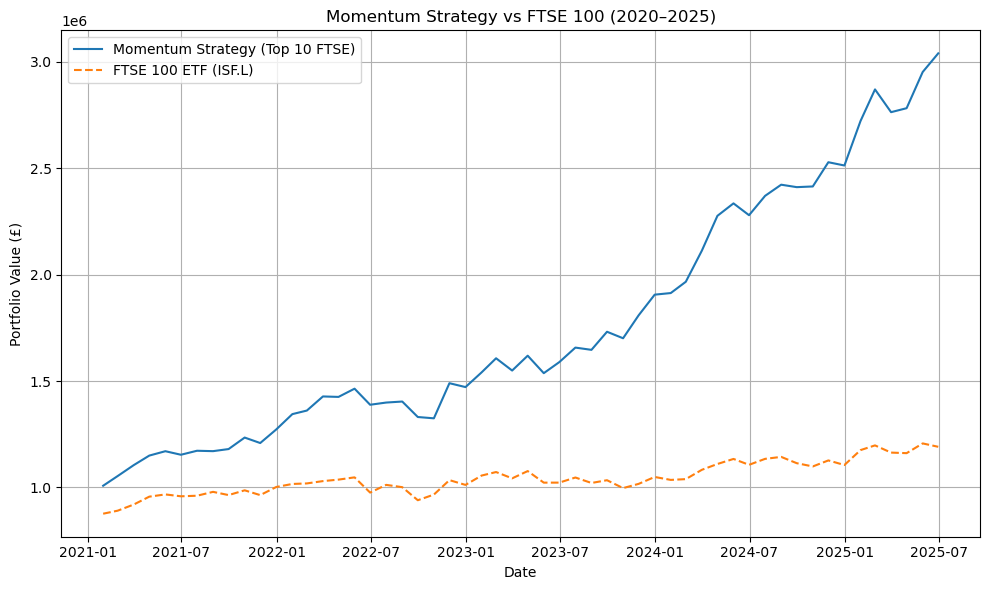

In [4]:
# First line has an error - you're trying to convert a string to an integer
print("Downloading FTSE 100 stock data...")  # Changed from int() to print()
raw_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Build DataFrame with Adj Close (or Close if adjusted)
adj_close = pd.concat([raw_data[ticker]['Close'] for ticker in tickers if 'Close' in raw_data[ticker]], axis=1)
adj_close.columns = [ticker for ticker in tickers if 'Close' in raw_data[ticker]]
data = adj_close.dropna(axis=1, how='any')  # Drop stocks with incomplete data
print(f"✅ Loaded data for {data.shape[1]} tickers.")

# --- 3. Calculate Monthly Returns and Momentum ---
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change()
momentum_scores = monthly_prices.pct_change(12)  # 12-month momentum

# --- 4. Backtest Momentum Strategy ---
initial_capital = 1_000_000
portfolio = pd.DataFrame(index=monthly_returns.index, columns=['Portfolio'])

# Fixed backtest loop - using iloc for both the date selection and stock selection
for i in range(12, len(momentum_scores)):
    # Get the current date
    current_date = momentum_scores.index[i]
    
    # Get the top 10 stocks based on momentum at this point in time
    top10 = momentum_scores.iloc[i].nlargest(10).index
    
    # Calculate the average return of these stocks for the current month
    monthly_ret = monthly_returns.loc[current_date, top10].mean()
    
    if i == 12:
        portfolio.loc[current_date, 'Portfolio'] = initial_capital * (1 + monthly_ret)
    else:
        prev_date = momentum_scores.index[i-1]
        portfolio.loc[current_date, 'Portfolio'] = portfolio.loc[prev_date, 'Portfolio'] * (1 + monthly_ret)

portfolio = portfolio.dropna()

# --- 5. Compare with FTSE 100 ETF (ISF.L) ---
print("Downloading FTSE 100 benchmark (ISF.L)...")
ftse_index = yf.download('ISF.L', start=start_date, end=end_date, auto_adjust=True)['Close']
ftse_monthly = ftse_index.resample('M').last().pct_change()
ftse_cum = (1 + ftse_monthly).cumprod() * initial_capital
ftse_cum = ftse_cum[ftse_cum.index.isin(portfolio.index)]  # Ensure matching dates

# --- 6. Plot Performance ---
plt.figure(figsize=(10, 6))
plt.plot(portfolio, label='Momentum Strategy (Top 10 FTSE)')
plt.plot(ftse_cum, label='FTSE 100 ETF (ISF.L)', linestyle='--')
plt.title("Momentum Strategy vs FTSE 100 (2020–2025)")
plt.ylabel("Portfolio Value (£)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()